In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the necessary functions from the file they are stored
from utils import apply_transformations_to_set, generate_qq_plot, compare_qq_plots

# Statistical tools
from scipy.stats import probplot, boxcox

# Train Val Test split
from sklearn.model_selection import train_test_split

# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram

# Display all columns of the DataFrame 
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv("CreditCardChurn.csv")

In [3]:
df.drop(columns=['CLIENTNUM','Avg_Open_To_Buy','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

## Train-Val-Test Split

In [4]:
X_train, X_temp = train_test_split(df, test_size=0.3 ,random_state=1)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=1)

In [5]:
X_train.shape, X_val.shape, X_test.shape 

((7088, 19), (1519, 19), (1520, 19))

## Data Imputing

### 'Unknown' values will be replaced with the mode of each column(Analysis showed that this is a very accurate way to impute values on all 3 columns)

In [6]:
dfs = [X_train, X_val, X_test]

# Calculate modes only on X_train to prevent data leakage
education_mode = X_train['Education_Level'].mode()[0]
marital_mode = X_train['Marital_Status'].mode()[0]
income_mode = X_train['Income_Category'].mode()[0]

# Replace X_train mode to all DataFrames
for df in dfs:
    df['Education_Level'].replace('Unknown', education_mode, inplace=True)
    df['Marital_Status'].replace('Unknown', marital_mode, inplace=True)
    df['Income_Category'].replace('Unknown', income_mode, inplace=True)

# Feature Engineering

In [7]:
epsilon = 1e-8
beta = 1.5 # Provide 1.5 times the weight to transaction amount over transaction count

for df in dfs:
    
    # New ratio for transaction change leveraging the harmonic mean to reflect proportional changes and be less sensitive to outliers(Formula similar to f1-score but with more weight on transaction amount)
    df['Trans_ratio_change'] = ((1 + beta) * df['Total_Amt_Chng_Q4_Q1'] * df['Total_Ct_Chng_Q4_Q1']) / (beta * df['Total_Amt_Chng_Q4_Q1'] + df['Total_Ct_Chng_Q4_Q1'] + epsilon)
   
   # Simple Amount Per Transaction column
    df['Amt_per_trans'] = df['Total_Trans_Amt'] / (df['Total_Trans_Ct'] + epsilon)

## Tranformations

In [8]:
numeric_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                   'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                   'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Credit_Limit', 'Avg_Utilization_Ratio']

categorical_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


Column: Customer_Age
Skewness Before Transformation: -0.04107057347112324
Best Transformation: boxcox
Skewness After Best Transformation: -0.01871697922762379


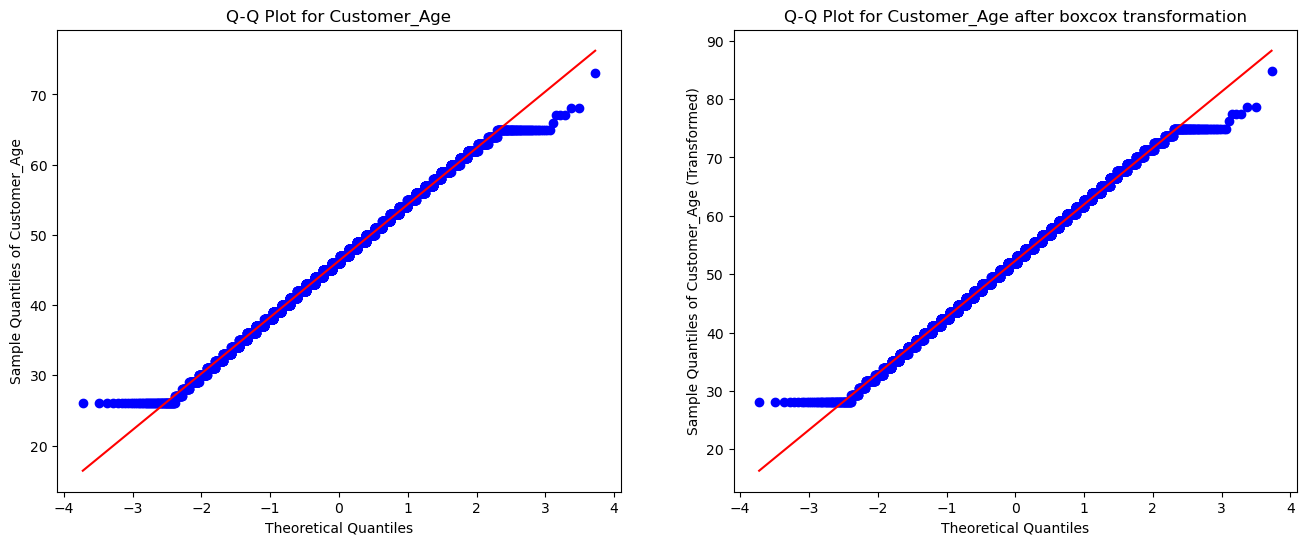

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Dependent_count
Skewness Before Transformation: -0.01461968004254675


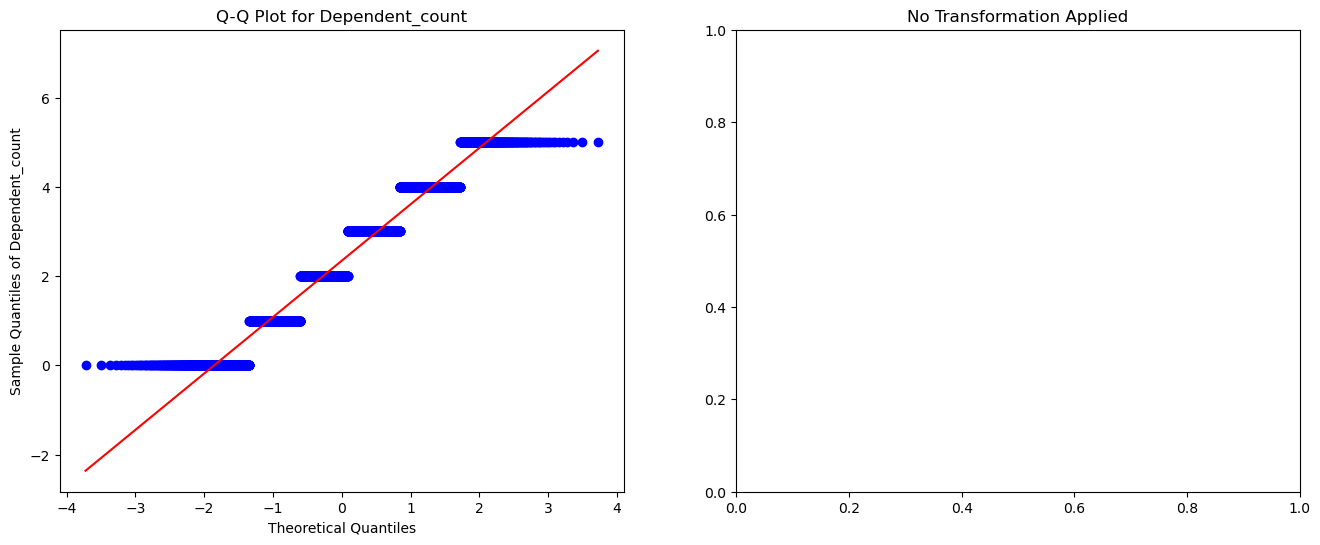

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Months_on_book
Skewness Before Transformation: -0.11684719650159021
Best Transformation: boxcox
Skewness After Best Transformation: 0.026694768392469332


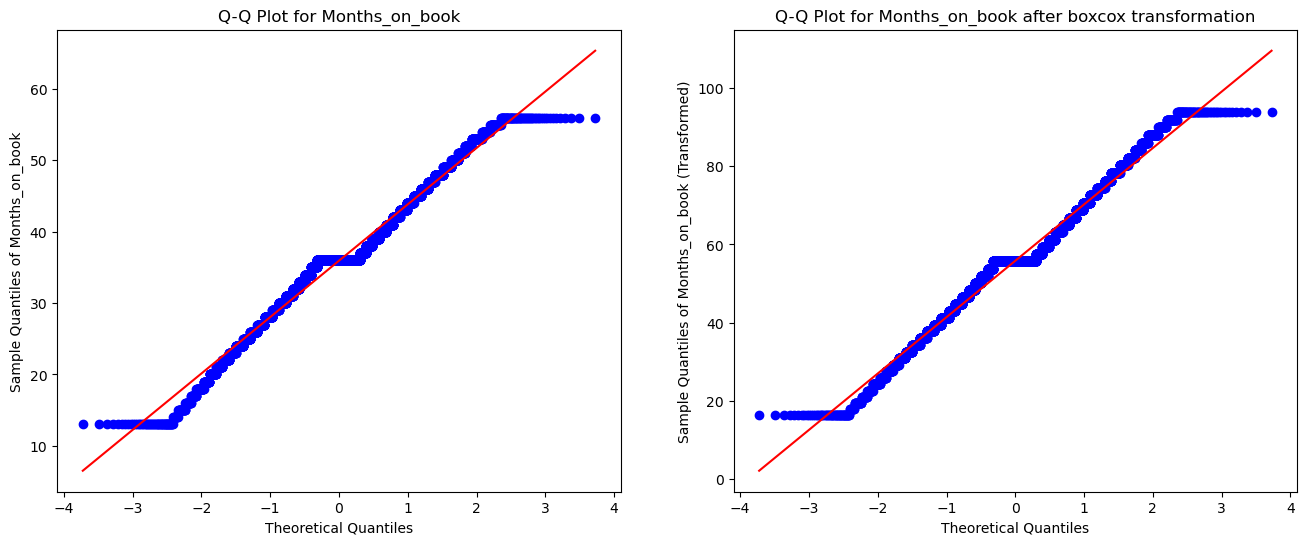

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Relationship_Count
Skewness Before Transformation: -0.15739027584238538


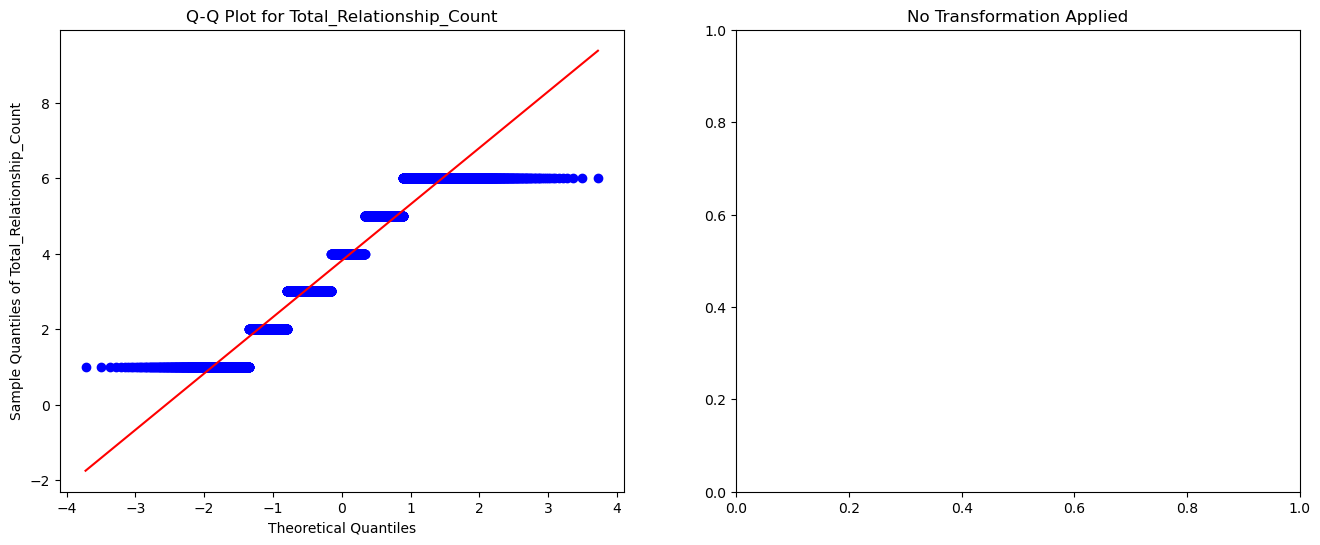

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Months_Inactive_12_mon
Skewness Before Transformation: 0.6591294640070973
Best Transformation: sqrt
Skewness After Best Transformation: -0.15267466316811926


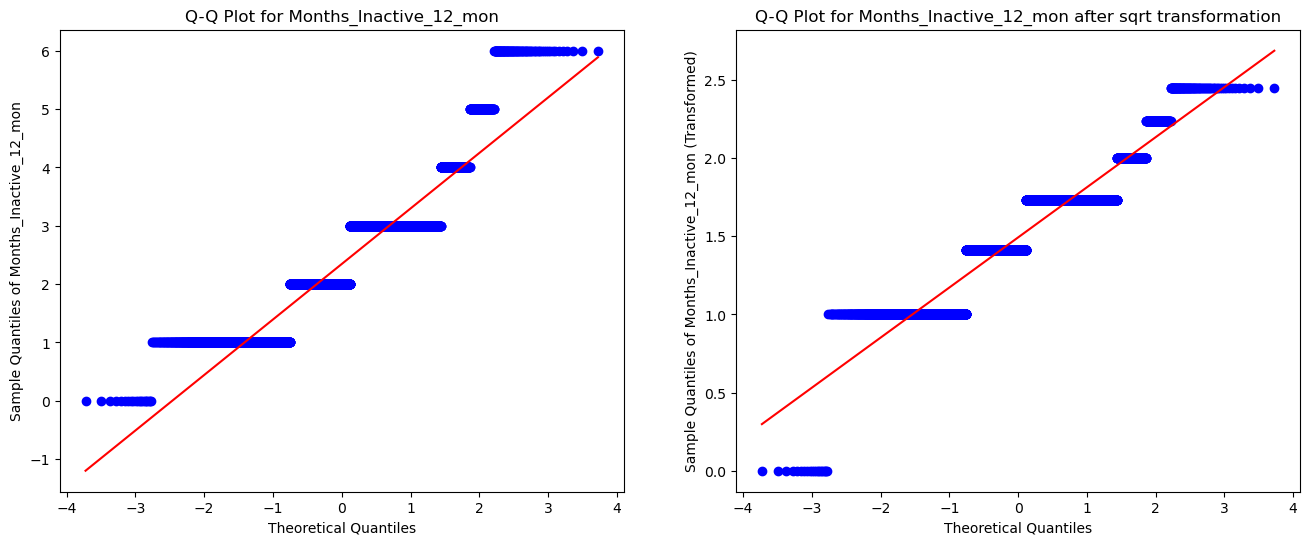

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Contacts_Count_12_mon
Skewness Before Transformation: -0.029577136289225377


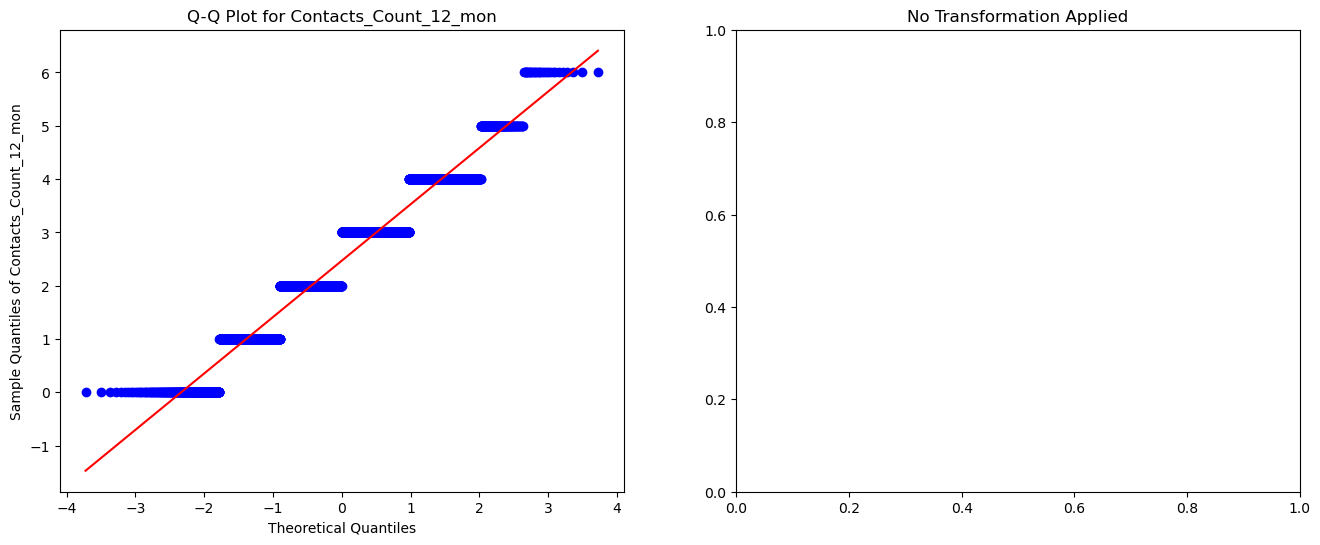

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Credit_Limit
Skewness Before Transformation: 1.6621100967313127
Best Transformation: boxcox
Skewness After Best Transformation: 0.10199801699235975


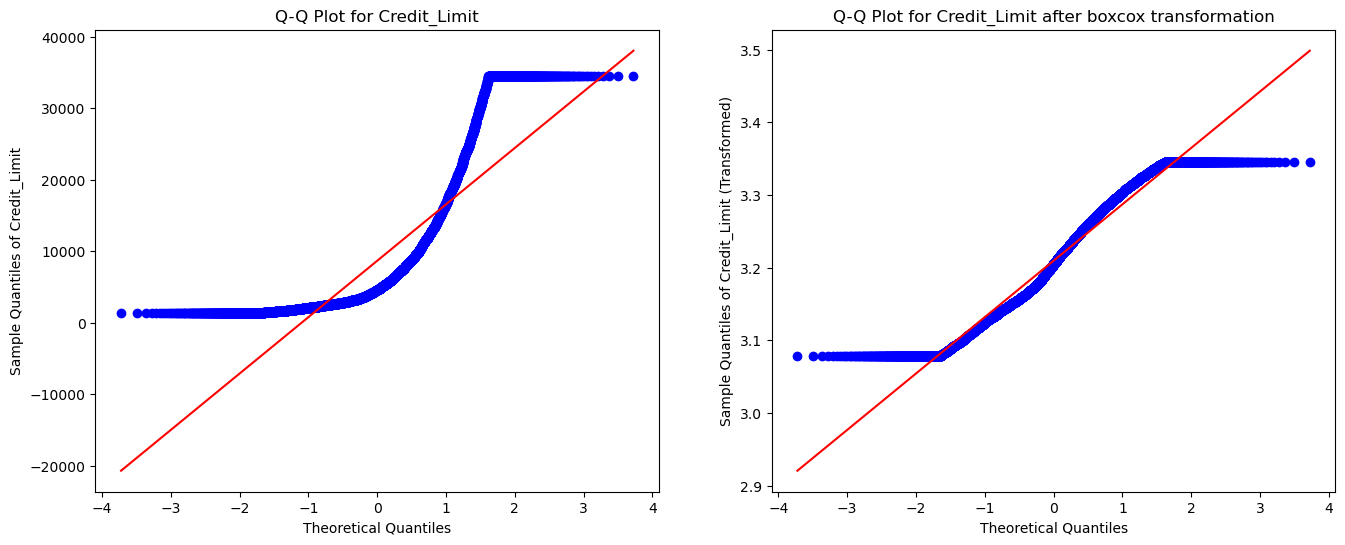

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Revolving_Bal
Skewness Before Transformation: -0.14261283434704822


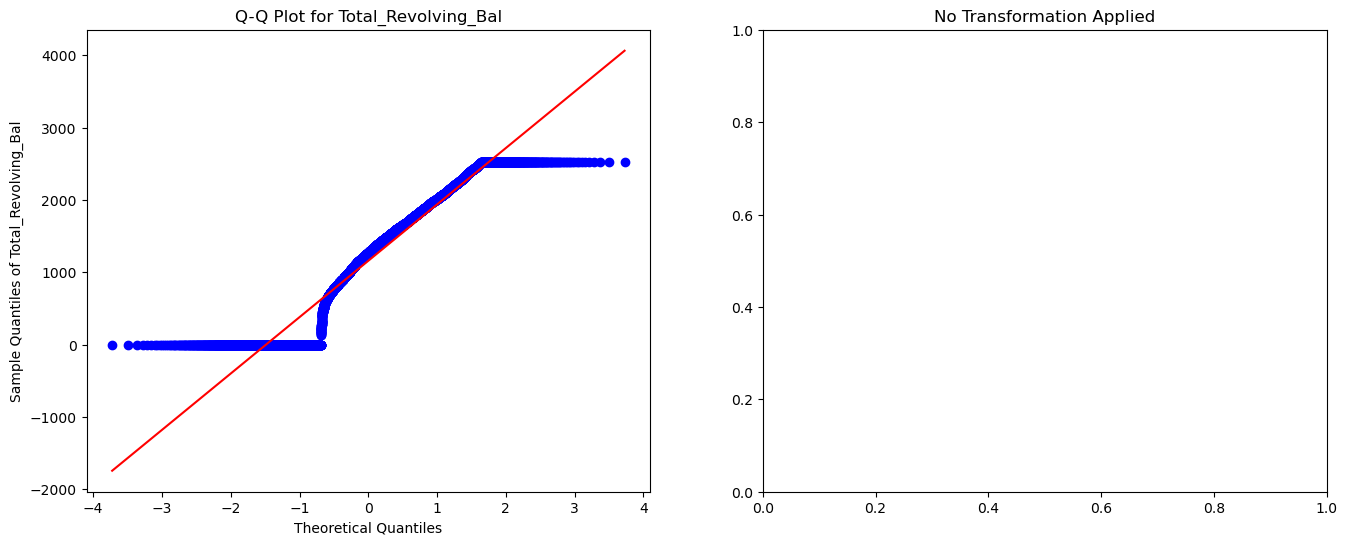

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Amt_Chng_Q4_Q1
Skewness Before Transformation: 1.8478368963605825
Best Transformation: sqrt
Skewness After Best Transformation: 0.4319988893186418


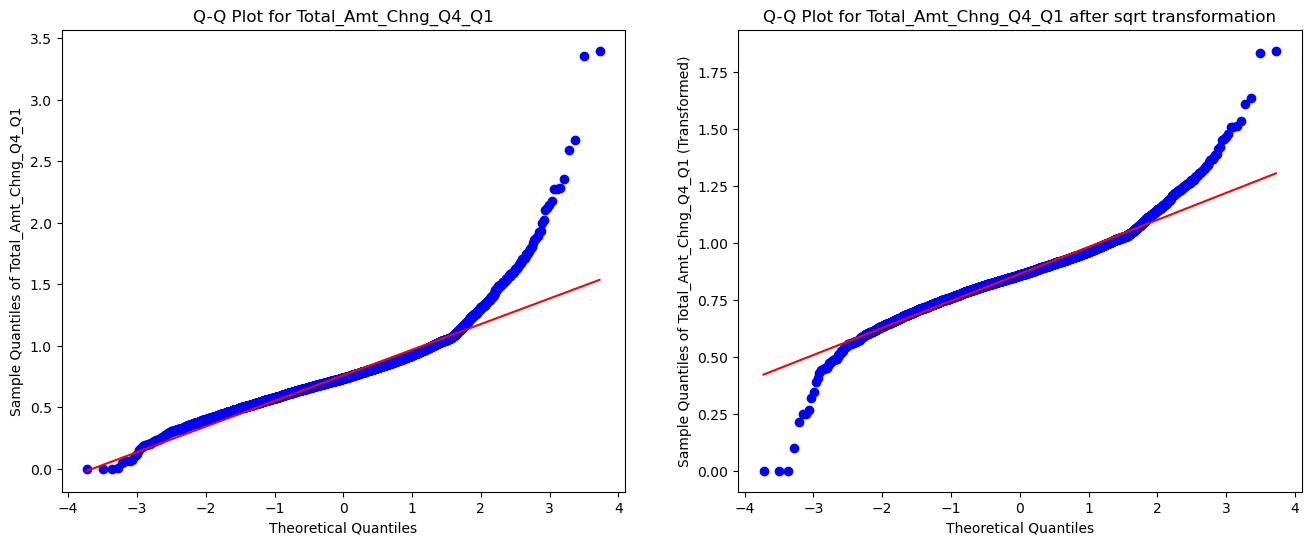

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Trans_Amt
Skewness Before Transformation: 2.0365005575342536
Best Transformation: boxcox
Skewness After Best Transformation: 0.0026769062982910786


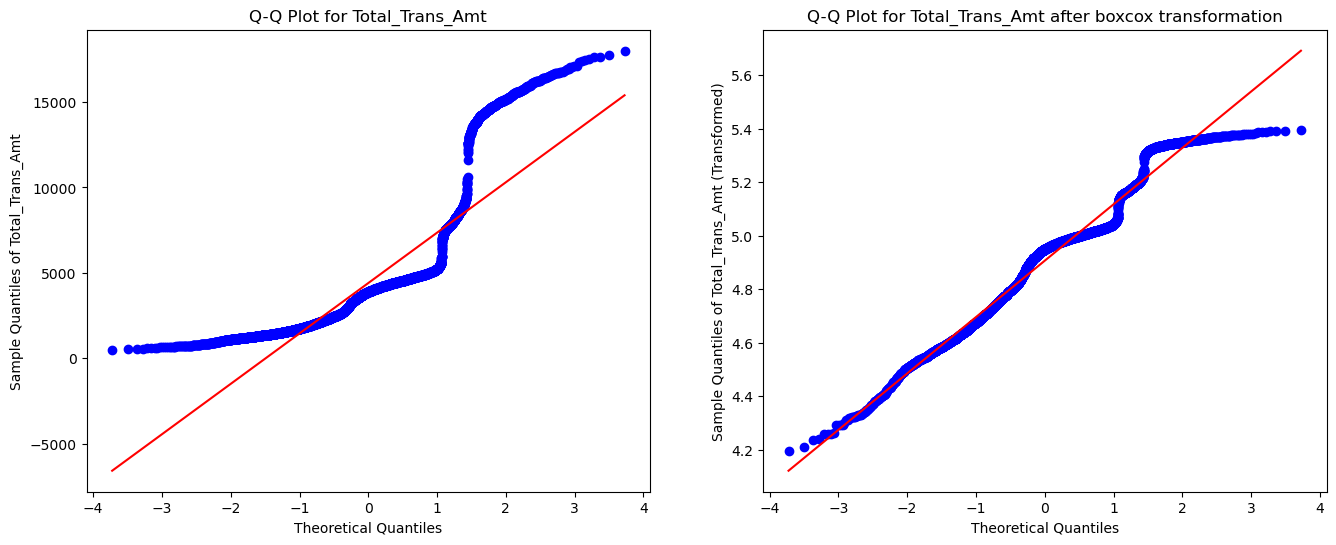

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Trans_Ct
Skewness Before Transformation: 0.1602069408582305
Best Transformation: boxcox
Skewness After Best Transformation: -0.06074056093989213


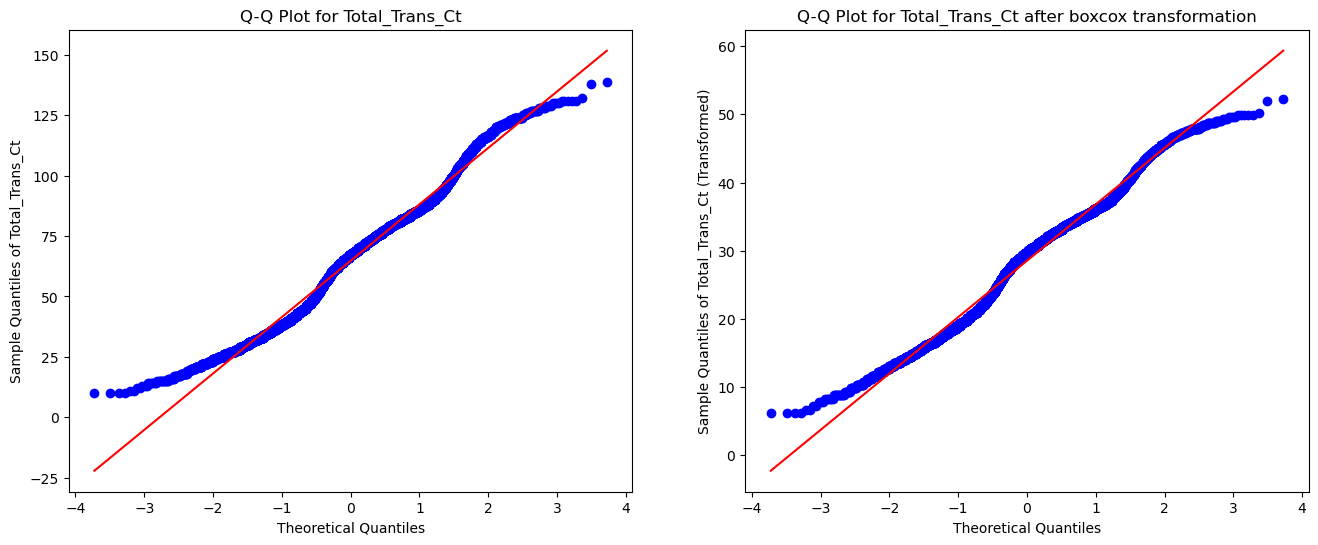

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Total_Ct_Chng_Q4_Q1
Skewness Before Transformation: 2.233124565931346
Best Transformation: sqrt
Skewness After Best Transformation: 0.2778928420864849


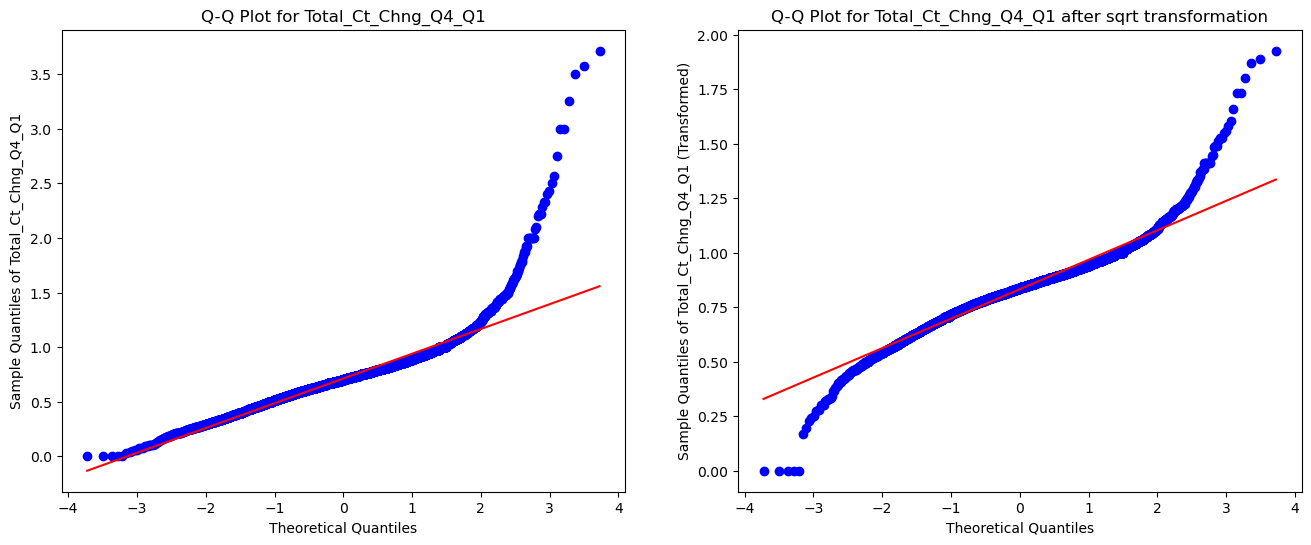

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Avg_Utilization_Ratio
Skewness Before Transformation: 0.7254223480503008
Best Transformation: sqrt
Skewness After Best Transformation: 0.008055518557461366


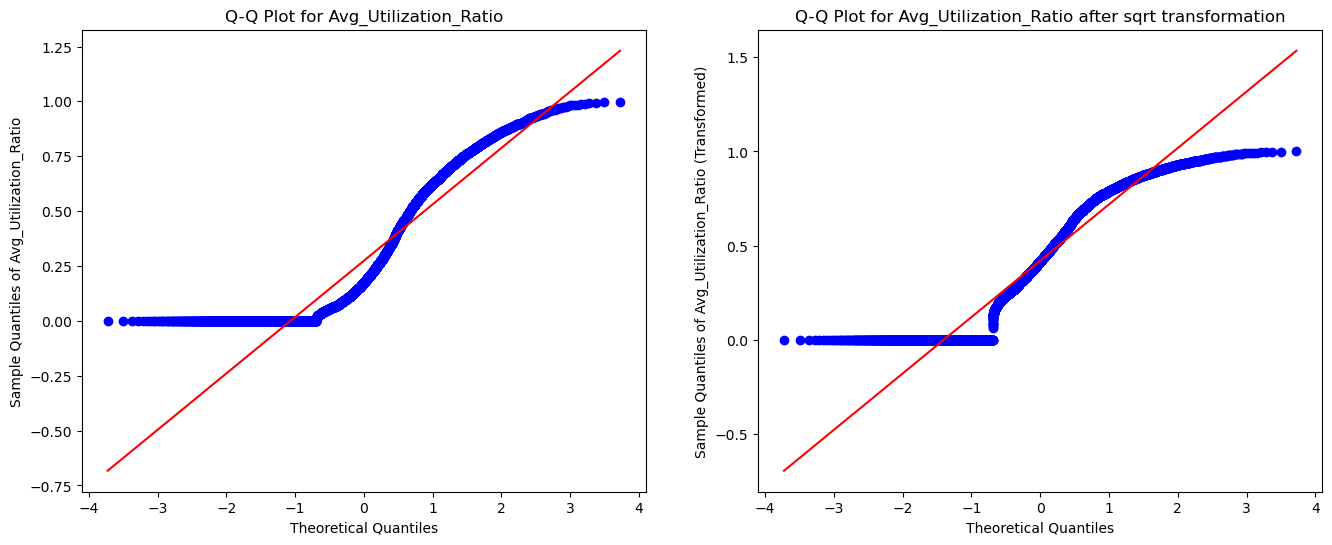

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Trans_ratio_change
Skewness Before Transformation: 1.6247614686055387
Best Transformation: sqrt
Skewness After Best Transformation: -0.14522172558475438


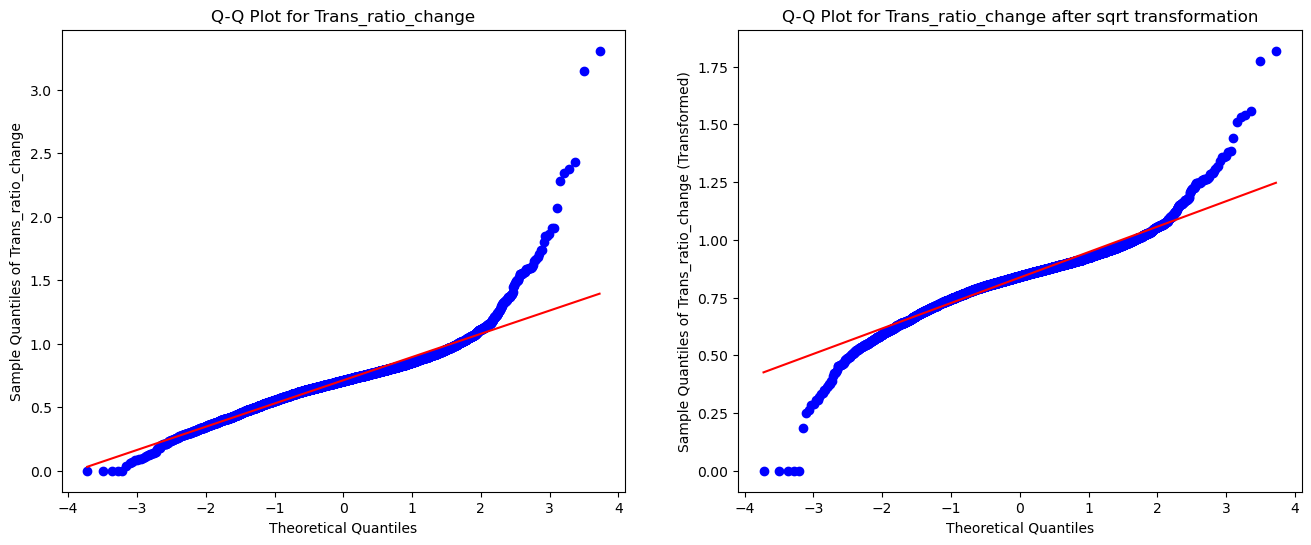

////////////////////////////////////////////////////////////////////////////////////////////////////

Column: Amt_per_trans
Skewness Before Transformation: 1.8639394203966237
Best Transformation: boxcox
Skewness After Best Transformation: -0.013648912981447646


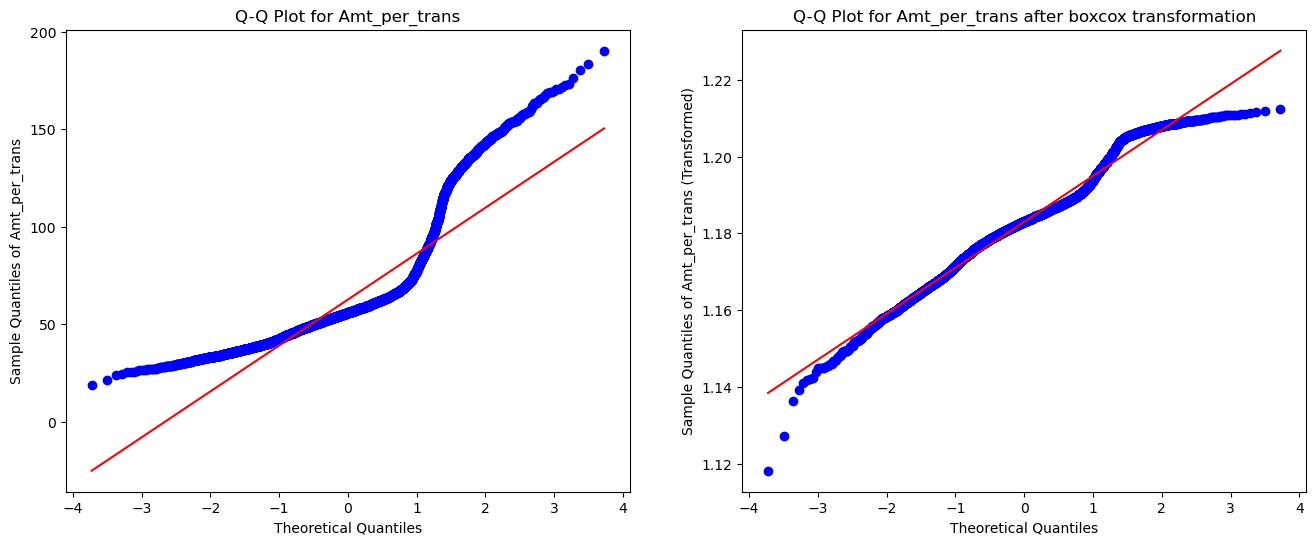

////////////////////////////////////////////////////////////////////////////////////////////////////


In [9]:
# List of transformations to consider
transformations = ['log', 'sqrt', 'reciprocal', 'square', 'boxcox']

# Apply transformations to training, validation, and test sets
X_train_transformed, applied_transformations_train = apply_transformations_to_set(X_train, transformations)
X_val_transformed, applied_transformations_val = apply_transformations_to_set(X_val, transformations)
X_test_transformed, applied_transformations_test = apply_transformations_to_set(X_test, transformations)

# Print results for X_train
for col in X_train.select_dtypes(include=['number']).columns:
    best_transformation = applied_transformations_train.get(col)
    original_data = X_train[col]
    transformed_data = X_train_transformed[col]

    print(f"\nColumn: {col}")
    skewness_before, skewness_after = original_data.skew(), transformed_data.skew()
    print(f"Skewness Before Transformation: {skewness_before}")
    
    # Print information if a transformation is applied
    if best_transformation:
        print(f"Best Transformation: {best_transformation}")
        print(f"Skewness After Best Transformation: {skewness_after}")
    
    # Generate and display Q-Q plots
    compare_qq_plots(original_data, transformed_data, col, transformation=best_transformation)
    print("//" * 50)

## Encoding

In [10]:
transformed_dfs = [X_train_transformed, X_val_transformed, X_test_transformed]

for df in transformed_dfs:

    df['Card_Category'].replace({'Blue': 1,
            'Silver' : 2,
            'Gold' : 3,
            'Platinum' : 4}, inplace=True)


    df['Income_Category'].replace({'Less than $40K' : 1,
                                    '$40K - $60K' : 2,
                                    '$60K - $80K' : 3,
                                    '$80K - $120K' : 4,
                                    '$120K +' : 5}, inplace = True)

    df['Education_Level'].replace({'Uneducated': 0,
                                    'High School': 1,
                                    'College': 2,
                                    'Graduate': 3,
                                    'Post-Graduate': 4,
                                    'Doctorate': 5},inplace=True)
    
    df['Gender'].replace({'F':'Female',
                          'M':'Male'}, inplace=True)

columns_to_encode = ['Gender', 'Marital_Status']


X_train_dummies = pd.get_dummies(X_train_transformed[columns_to_encode], drop_first=True).astype(int)
X_train_encoded = pd.concat([X_train_transformed, X_train_dummies], axis=1)
X_train_encoded.drop(columns=columns_to_encode, inplace=True)

X_val_dummies = pd.get_dummies(X_val_transformed[columns_to_encode], drop_first=True).astype(int)
X_val_encoded = pd.concat([X_val_transformed, X_val_dummies], axis=1)
X_val_encoded.drop(columns=columns_to_encode, inplace=True)

X_test_dummies = pd.get_dummies(X_test_transformed[columns_to_encode], drop_first=True).astype(int)
X_test_encoded = pd.concat([X_test_transformed, X_test_dummies], axis=1)
X_test_encoded.drop(columns=columns_to_encode, inplace=True)

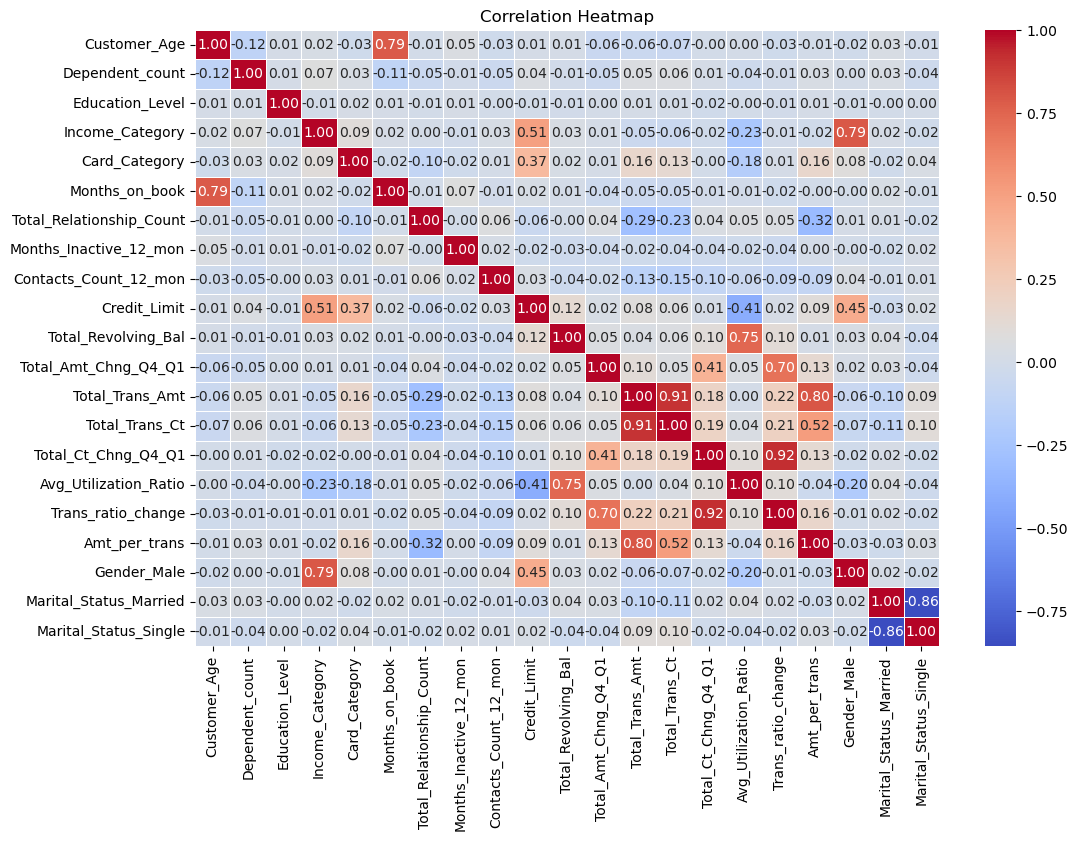

In [11]:
# Print correlations
correlation_matrix = X_train_encoded.drop(columns=['Attrition_Flag']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### Reason for dropping each column:
- #### **Customer Age**: High correlation with Months on Book, which is more representative of the customer's behavior
- #### **Income Category**: High correlation with gender. Also, a lot of Unknown values. It is not always easy to know the customer's income.
- #### **Total Transaction Amount/Count**: High correlation with each other and with Amount Per Transaction, whichi is more useful to understand customer behavior.
- #### **Total Amount/Count Change**: Created a unified ratio, representative of customer's change in activity.
- #### **Marital Status Single**: High negative correlation with Marital Status Married. Not important as well, since we know if they are married.
- #### **Average Utilization Ratio**: High correlation with Total Revolvng Balance, which is a very useful feature to cluster and classify customers.

In [12]:
encoded_dfs = [X_train_encoded, X_val_encoded, X_test_encoded]

for df in encoded_dfs:
    df.drop(columns=['Customer_Age','Income_Category','Total_Trans_Amt','Total_Trans_Ct','Avg_Utilization_Ratio','Marital_Status_Single','Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1'],inplace=True)

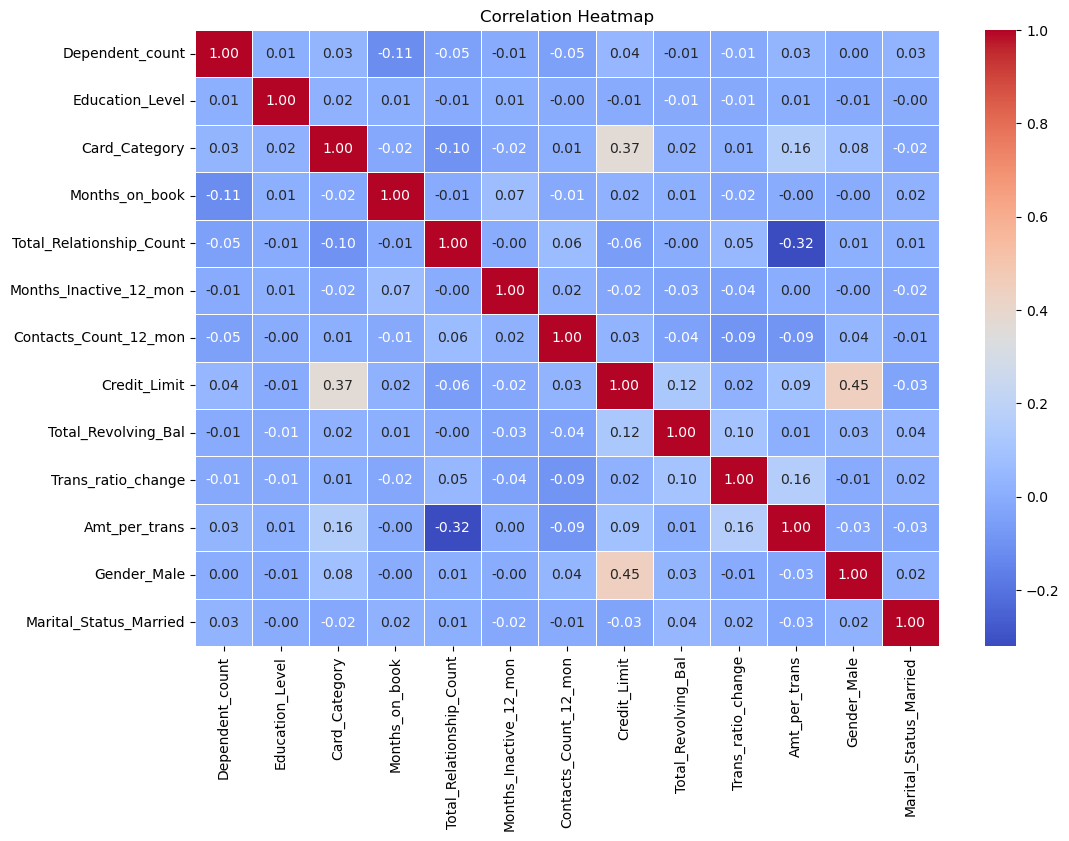

In [13]:
correlation_matrix = X_train_encoded.drop(columns=['Attrition_Flag']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

## Scaling

In [14]:
scaler = MinMaxScaler()

columns_to_scale = X_train_encoded.drop(columns=['Gender_Male', 'Marital_Status_Married','Attrition_Flag']).columns

# Scale selected columns based on X_train data
X_train_scaled = scaler.fit_transform(X_train_encoded[columns_to_scale])
X_val_scaled = scaler.transform(X_val_encoded[columns_to_scale])
X_test_scaled = scaler.transform(X_test_encoded[columns_to_scale])

# Combine scaled columns with the columns to keep
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=columns_to_scale).reset_index(drop=True), X_train_encoded[['Gender_Male', 'Marital_Status_Married']].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([pd.DataFrame(X_val_scaled, columns=columns_to_scale).reset_index(drop=True), X_val_encoded[['Gender_Male', 'Marital_Status_Married']].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=columns_to_scale).reset_index(drop=True), X_test_encoded[['Gender_Male', 'Marital_Status_Married']].reset_index(drop=True)], axis=1)

X_train_churn = pd.concat([pd.DataFrame(X_train_scaled, columns=columns_to_scale).reset_index(drop=True), X_train_encoded[['Gender_Male', 'Marital_Status_Married', 'Attrition_Flag']].reset_index(drop=True)], axis=1)
X_val_churn = pd.concat([pd.DataFrame(X_val_scaled, columns=columns_to_scale).reset_index(drop=True), X_val_encoded[['Gender_Male', 'Marital_Status_Married', 'Attrition_Flag']].reset_index(drop=True)], axis=1)
X_test_churn = pd.concat([pd.DataFrame(X_test_scaled, columns=columns_to_scale).reset_index(drop=True), X_test_encoded[['Gender_Male', 'Marital_Status_Married', 'Attrition_Flag']].reset_index(drop=True)], axis=1)

In [15]:
X_train_churn.to_csv('X_train_no_selection.csv', index=False, mode='w')
X_val_churn.to_csv('X_val_no_selection.csv', index=False, mode='w')
X_test_churn.to_csv('X_test_no_selection.csv', index=False, mode='w')

# Feature Selection

## Dendrogram Analysis

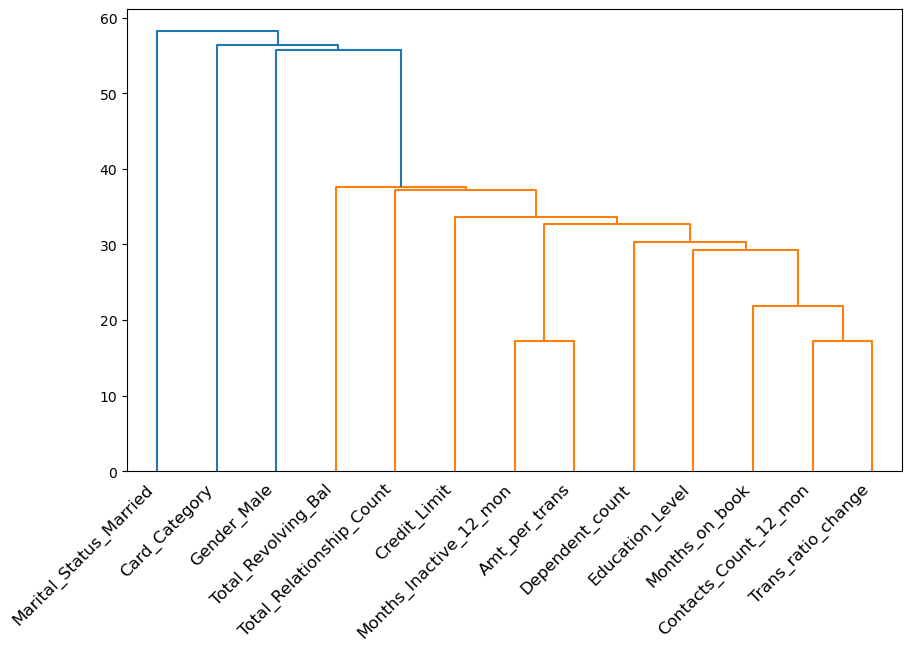

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

linkage_matrix = linkage(X_train_final.T, method='ward')
dendrogram(linkage_matrix, labels=X_train_final.columns, orientation='top')
plt.xticks(rotation=45, ha='right')

plt.show()

## Variance Threshold

In [17]:
threshold = 0.02
selector = VarianceThreshold(threshold)

# Fit the selector to the data and transform the data
X_reduced = selector.fit_transform(X_train_final)

# Print the results
print("Original data shape:", X_train_final.shape)
print("Reduced data shape:", X_reduced.shape)
print("")
# If you want to get the indices of the selected features
selected_indices = np.where(selector.get_support())[0]
selected_feature_names = [X_train_final.columns[i] for i in selected_indices]
print("Selected feature names:", selected_feature_names)

print("")

dropped_feature_names = [X_train_final.columns[i] for i in range(len(X_train_final.columns)) if i not in selected_indices]
print("Dropped feature names:", dropped_feature_names)

Original data shape: (7088, 13)
Reduced data shape: (7088, 9)

Selected feature names: ['Dependent_count', 'Education_Level', 'Months_on_book', 'Total_Relationship_Count', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Gender_Male', 'Marital_Status_Married']

Dropped feature names: ['Card_Category', 'Months_Inactive_12_mon', 'Trans_ratio_change', 'Amt_per_trans']


### From this analysis, it is shown that Transaction Ratio, Amount Per Transaction and number of inactive months do not contribute so much to the clustering process. Thus, they are dropped. 

In [18]:
final_dfs = [X_train_final, X_val_final, X_test_final, X_train_churn, X_val_churn, X_test_churn]

for df in final_dfs:
    df.drop(columns=['Amt_per_trans','Trans_ratio_change','Months_Inactive_12_mon'], inplace=True)

In [19]:
# Save the clustering DataFrames
X_train_final.to_csv('X_train.csv', index=False, mode='w')
X_val_final.to_csv('X_val.csv', index=False, mode='w')
X_test_final.to_csv('X_test.csv', index=False, mode='w')

X_train_churn.to_csv('X_train_churn.csv', index=False, mode='w')
X_val_churn.to_csv('X_val_churn.csv', index=False,mode='w')
X_test_churn.to_csv('X_test_churn.csv', index=False,mode='w')